In [1]:
import warnings

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pprint

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model
from sklearn import datasets

from scipy import stats

from tp_knn_source import (rand_bi_gauss, rand_tri_gauss,
                           rand_clown, rand_checkers, plot_2d,
                           frontiere_new, ErrorCurve, LOOCurve
                          )

warnings.filterwarnings('ignore')
sns.set()

In [2]:
#GLobal vars
X2, y2, X3, y3, Xc, yc, Xch, ych = 0, 0, 0, 0, 0, 0, 0, 0
score = None 
digit_X_train, digit_y_train, digit_X_test, digit_y_test = 0, 0, 0, 0
digits_data = None

In [3]:
# common functions
def split_data(X, y):
    return (X[::2], y[::2], X[1::2], y[1::2])

def gen_bi_gauss_prop(n,m, t_size=0.2):
    X,y = rand_bi_gauss(n1=m, n2=n-m,
                        mu1=(1,1), mu2=(-1,-1),
                        sigmas1=(0.9,0.9), sigmas2=(0.9,0.9))
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size)
    return X_train, X_test, y_train, y_test
    

# k-plus proches voisins

## Question 1

In [4]:
def gen_rand():
    X2,y2 = rand_bi_gauss(n1=20,n2=20,mu1=(1,1),mu2=(-1,-1),
                   sigmas1=(0.9,0.9), sigmas2=(0.9,0.9))
    
    X3,y3 = rand_tri_gauss(n1=50, n2=50, n3=50,
                    mu1=(1,1), mu2=(-1,-1), mu3=(1,-1),
                    sigma1=(0.9,0.9), sigma2=(0.9,0.9), sigma3=(0.9,0.9))
    
    Xc, yc = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)
    
    Xch, ych = rand_checkers(n1=150, n2=150)
    
    return ( X2, y2,
             X3, y3,
             Xc, yc,
             Xch, ych
           )

In [5]:
X2, y2, X3, y3, Xc, yc, Xch, ych = gen_rand()

## Question 2

In [6]:
def plot_all():
    plt.close("all") 
    plt.figure(1, figsize=(15, 5))
    
    plt.subplot(141)
    plt.title('rand_bi_gauss')
    plot_2d(X2, y2)
    
    plt.subplot(142)
    plt.title('rand_tri_gauss')
    plot_2d(X3, y3)
    
    plt.subplot(143)
    plt.title('rand_clown')
    plot_2d(Xc, yc)
    
    plt.subplot(144)
    plt.title('rand_checkers')
    plot_2d(Xch, ych)
    
    plt.show()

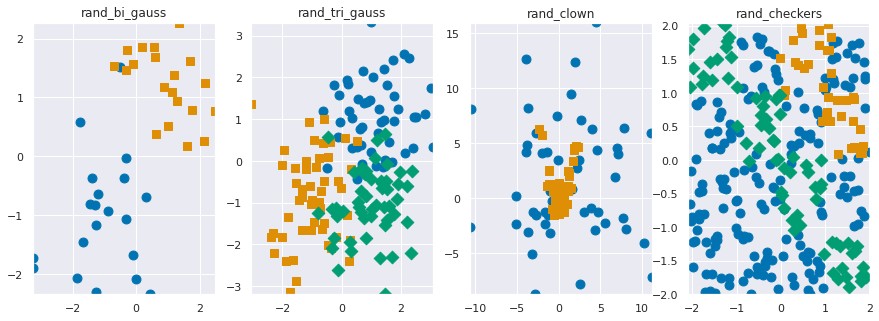

In [7]:
plot_all()

## Question 3

On détermine les k-plus proches voisins $V_k(x)$ parmi le trainset pour un nouveau point $x$. la valeur de $y$ qu'on affectera au nouveau point $x$ sera la moyenne des $y$ (la variable à expliquer) qui correspondent aux k-plus proches voisins $V_k(x)$.

## Question 4

In [8]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        dist = np.zeros((X.shape[0],self.X.shape[0]))
        for row in range(X.shape[0]):
            for col in range(self.X.shape[0]):
                dist[row][col] = np.linalg.norm( X[row] - self.X[col])
  
        ind_sort = np.argsort(dist, axis=1)
        ind_neighbors = ind_sort[:, :self.n_neighbors]     
        Y_neighbors = self.y[ind_neighbors]
        
        mode, _ = stats.mode(Y_neighbors, axis=1)
        y_pred = np.asarray(mode.ravel(), dtype=np.intp)
        
        return y_pred

In [9]:
class TestKnn:
    def __init__(self, KnnClass,n_neighbors, X, y):
        
        self.knnClass = KnnClass
        self.knn      = self.knnClass(n_neighbors)
        
        self.knnClassOrig = KNeighborsClassifier
        self.knnOrig      = self.knnClassOrig(n_neighbors)
        
        self.X_train  = X[::2]
        self.y_train  = y[::2]
        
        self.X_test   = X[1::2]
        self.y_test   = y[1::2]
    
    def fit(self):
        self.knn.fit(self.X_train, self.y_train)
        self.knnOrig.fit(self.X_train, self.y_train)
        
    def test(self):
        knn_pred = self.knn.predict(self.X_test)
        knnOrig_pred = self.knnOrig.predict(self.X_test)
        
        return (knn_pred - knnOrig_pred).mean()
        

In [10]:
testknn = TestKnn(KNNClassifier, 5, X3, y3)
testknn.fit()
diff = testknn.test()
print("La différence moyenne entre ke knn implémenté ci-dessus et ce lui de sklearn est de %f"%diff)

La différence moyenne entre ke knn implémenté ci-dessus et ce lui de sklearn est de 0.000000


## Question 5

In [11]:
def classifAll():
    knn = KNeighborsClassifier(n_neighbors=5)
    
    def f_pred(x):
        return knn.predict(x.reshape(1, -1))
    
    for X, y, i in [(X2,y2,1), (X3,y3,2), (Xc,yc,3), (Xch,ych,4)]:
        knn.fit(X,y)
        plt.figure()
        plt.title('#%d'%i)
        frontiere_new(f_pred, X, y)

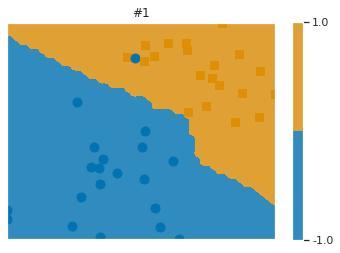

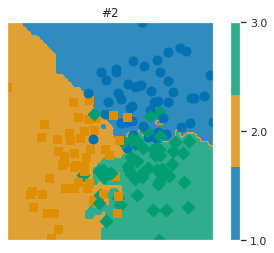

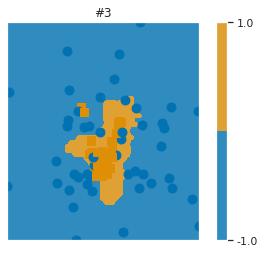

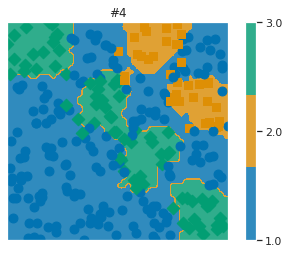

In [12]:
classifAll()

## Question 6

In [13]:
def varyK():
    X_train = X3[::2]
    y_train = y3[::2]
    X_test  = X3[1::2]
    y_test  = y3[1::2]
    
    n = X_train.shape[0]
    step = 5
    nb_plot = n//step +1
    
    score = {}
    
    plt.close("all") 

    
    for k, k_plot in zip(range(0,n+1,step), range(0,nb_plot)):
        plt.figure(1, figsize=(15, 5))
        if k == 0 : k = 1
        plt.subplot(1, 4, k_plot%4+1)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        score[k] = knn.score(X_test, y_test)
        
        def f_pred(x):
            return knn.predict(x.reshape(1, -1))
        
        plt.title('k=%d score %f'%(k,score[k]))
        frontiere_new(f_pred, X_train, y_train)
        if k_plot%4 +1 == 4: plt.show()
    
    return score

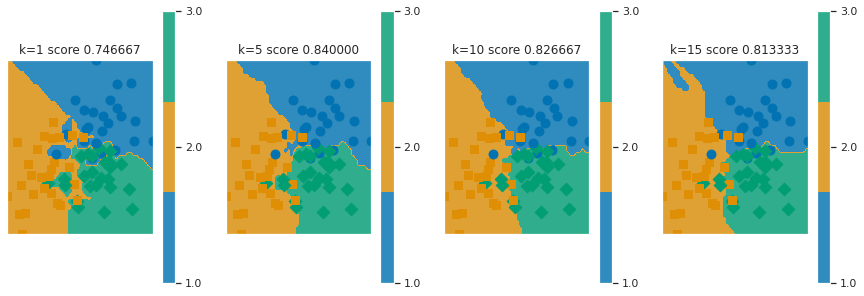

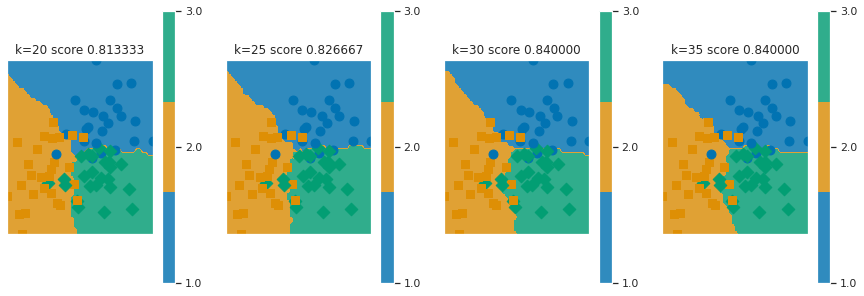

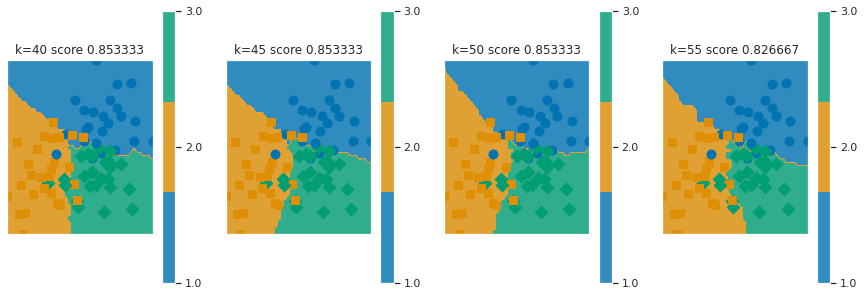

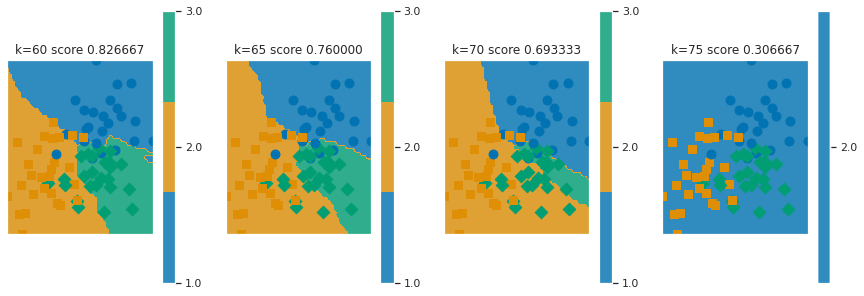

In [14]:
score = varyK()

In [15]:
def plot_score(score_dict):
    plt.close("all") 
    plt.figure(1, figsize=(5, 5))
    plt.scatter(list(score.keys()), list(score.values()))
    plt.title("Score pour k de 1 à 75")
    plt.xlabel("k")
    plt.ylabel("score")
    plt.show()  

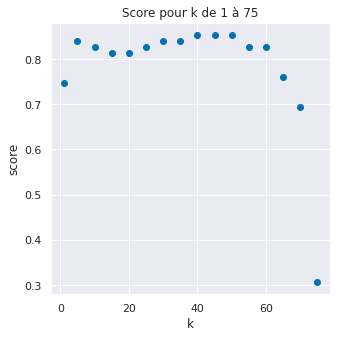

In [16]:
plot_score(score)

- Pour $k = 1$:
    - On prend qu'un seul point, le modèle devient très sensible aux donnés aberrantes, on se retrouve dans un cas de overfitting.
- Pour $k = n$:
    - On prend en compte tous les points du trainset, la prédiction devient constante et elle correspond au label qui contient le plus de points.

Plus $k$ est grand plus frontière devient simple et inversement plus $k$ est petit plus la frontiète devient complexe.

## Question 7

In [17]:
def VisuWithWeight(X,y):
    k = 7
    all_j = [-2, -1, 0, 1, 2]
            
    X_train  = X[::2]
    y_train  = y[::2]
        
    X_test   = X[1::2]
    y_test   = y[1::2]
    
    plt.close("all") 
    
    for j,i in zip(all_j, range(5)):        
        knn = KNeighborsClassifier(n_neighbors=k, weights=lambda d: np.exp(-d**2/10**j))
        knn.fit(X_train, y_train)
        
        def f_pred(x):
            return knn.predict(x.reshape(1, -1))
        
        plt.figure(1, figsize=(15, 5))
        plt.subplot(1, 2, i%2+1)
        plt.title('h=10^%d'%j)
        frontiere_new(f_pred, X_test, y_test)
        if i%2+1 == 2 :plt.show()

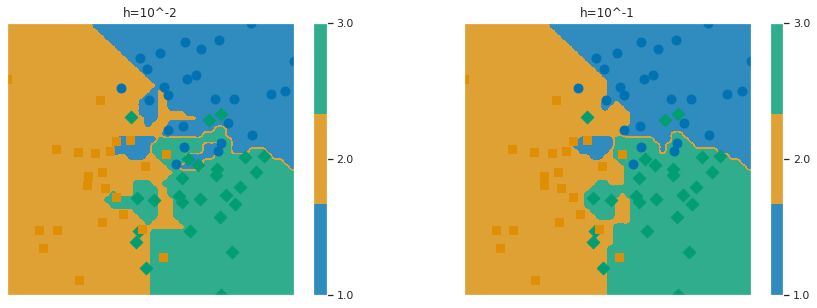

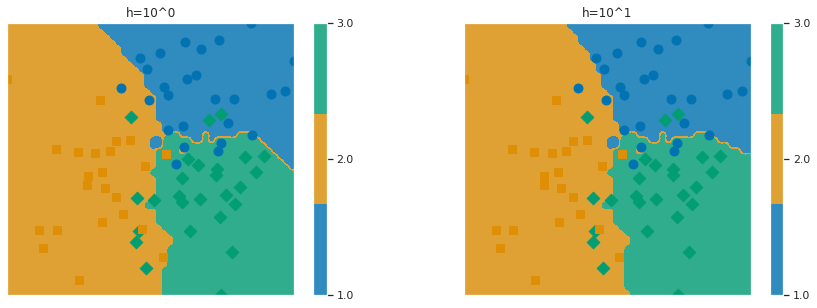

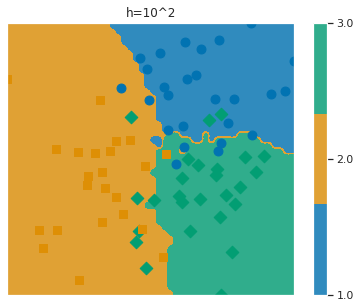

In [18]:
VisuWithWeight(X3,y3)

## Question 8

In [19]:
def get_error_rate(k,X,y):                
    X_train  = X[::2]
    y_train  = y[::2]
        
    X_test   = X[1::2]
    y_test   = y[1::2]
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred_train = knn.predict(X_train)
    y_pred_test  = knn.predict(X_test)
    error_train = (y_pred_train != y_train).mean()
    error_test  = (y_pred_test  != y_test).mean()
    print("le taux d'error pour le train set avec k=1 est de: %f"%error_train)
    print("le taux d'error pour le test set avec k=1 est de:  %f"%error_test)


In [20]:
get_error_rate(1,X3, y3)

le taux d'error pour le train set avec k=1 est de: 0.000000
le taux d'error pour le test set avec k=1 est de:  0.253333


## Question 9

In [21]:
def VisuError(X,y,n):
    
    X_train, y_train, X_test, y_test = split_data(X, y)
    
    error_curve = ErrorCurve(k_range=range(1,n+1))
    error_curve.fit_curve(X_train, y_train, X_test, y_test)
    error_curve.plot()

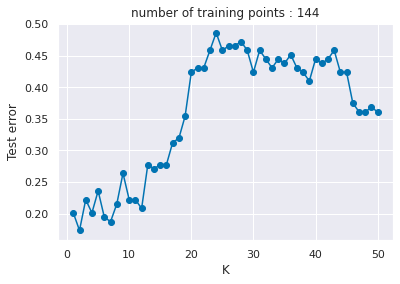

In [22]:
VisuError(Xch, ych, 50)

## Question 10

In [23]:
def VisuMultiError(k_max=50):
    
    plt.close()
    plt.figure(figsize=(12,10))
    sig = 0.1
    
    n_samples = [100, 200, 500, 1000]   
    colors  = ['red', 'blue', 'brown', 'green']
    best_ks = [] 
    for i, n in enumerate(n_samples):
        X_train, Y_train = rand_checkers(n, n, sig)
        X_test, Y_test = rand_checkers(n, n, sig)
        
        error_curve = ErrorCurve(k_range=range(1,k_max+1))
        error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
        best_ks.append(np.argmin(error_curve.errors[9:])+10)
        error_curve.plot(color=colors[i], maketitle=False)
    plt.title("Le taux d'erreur avec différentes valeurs de k")
    plt.legend(["train_size:%04d best_k:%02d " %(s,_k) for _k,s in zip(best_ks,n_samples)],loc='upper left')    

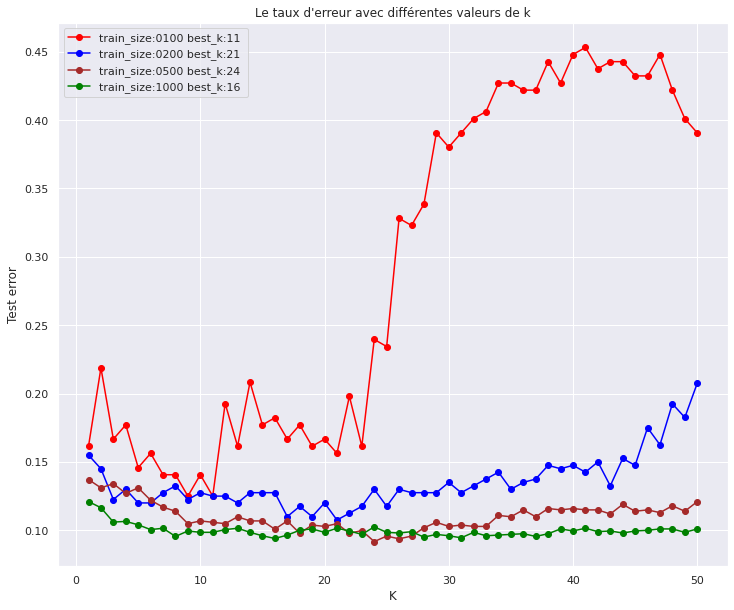

In [24]:
VisuMultiError()

D'après les courbes du taux d'erreur, la valeur optimale de $k$ est différente selon la taille de l'ensemble de l'entrainement.
- On peut tout simplement prendre les $k$ avec le plus petit taux d'erreur et supérieur à 10 (pour éviter l'overfitting) :
    - pour $k=100$  on prend $k=11$
    - pour $k=200$  on prend $k=21$
    - pour $k=500$  on prend $k=24$
    - pour $k=1000$ on prend $k=16$

### Question 11

L'algorithme parcourt tous les points de l'entrainement lors de chaque prédiction, et donc plus $n$ est grand plus l'algorithme prendra du temps pour une prédiction. Ceci rend aussi le passage à l'échelle très compliqué. Cependant l'algorithme du $k$-nn est très basique ce qui le rend assez simple à interpréter et cela est considéré comme un avantage, car on demande de plus en plus d'avoir des IA explicables.

### Question 12

La méthode `load_digits` renvoi un objet de type `sklearn.utils.Bunch`, de cet objet on va utiliser les attributs `data` et `target` (mais contient aussi `images` et `target_name`) qui sont des numpy arrays de taille `19797` composés de:

- `images`: un numpy 2D-arrays de taille 8x8 (pixels) qui contient les intensité de gris \[0,16\] .
-  `data`: pareil comme `images` mais sous forme d'un numpy array unidemensionel de taille 64 .
- `target`: un numpy int64 qui correspond à la classe de l'image ou plutot le chiffre qui correspond à l'image.
- `target_name`: le nom de la classe.
- `DESCR`: Contient la documentation.



Donc on a dataset de `1797` éléments et `10` classes de 0 à 9.

In [25]:
def load_digits():
    return datasets.load_digits()

In [26]:
def split_digits(digits_data):
    n = digits_data.data.shape[0]
    
    digit_X_train = digits_data.data[:n//2]
    digit_y_train = digits_data.target[:n//2]
    digit_X_test  = digits_data.data[n//2:]
    digit_y_test  = digits_data.target[n//2:]
    
    return digit_X_train, digit_y_train, digit_X_test, digit_y_test

In [27]:
def show_example_digit(digits_data):
    plt.close()
    plt.figure(figsize=(13,10))
    
    for i, (image, label) in enumerate(zip(digits_data.images[:10], digits_data.target[:10])):
        plt.subplot(2, 10, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%i'%label)

In [28]:
digits_data = load_digits()
digit_X_train, digit_y_train, digit_X_test, digit_y_test = split_digits(digits_data)

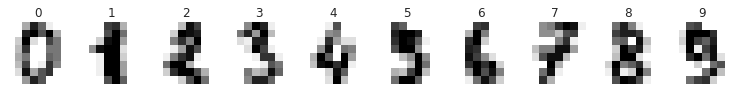

In [29]:
show_example_digit(digits_data)

In [32]:
def ShowClassesHist(digits_data):      
    plt.close("all")    
    for _class in np.unique(digits_data.target):
        plt.figure(1, figsize=(15, 3))
        plt.subplot(1, 5, _class%5+1)
        plt.title('class = %d'%_class)
        plt.hist(np.sum(digits_data.data[digits_data.target==_class], axis=1))
        if _class%5 == 4: plt.show()       

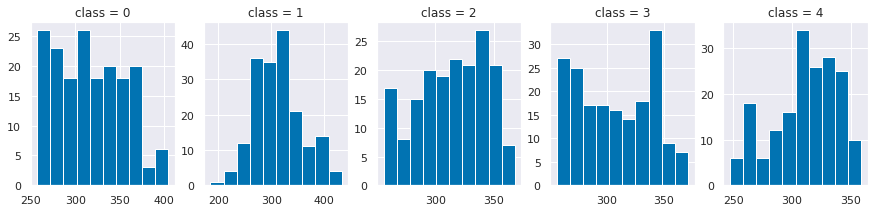

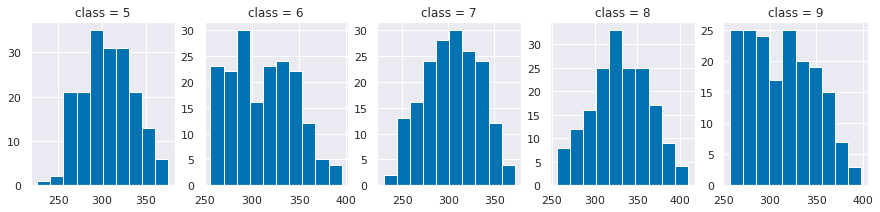

In [33]:
ShowClassesHist(digits_data)

In [34]:
def KnnDigits(k,X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error_test  = (y_pred != y_test).mean()
    print("Number of errors: %f"%error_test )

In [35]:
KnnDigits(30,digit_X_train, digit_y_train, digit_X_test, digit_y_test)

Number of errors: 0.074527


### Question 13

In [36]:
def ShowConfusionMatrix(k,X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier(n_neighbors=k)
    classifier = knn.fit(X_train, y_train)
    
    disp = ConfusionMatrixDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            display_labels=digits_data.target_names,
            cmap=plt.cm.Blues,
            normalize=None,
    )
    disp.ax_.set_title('Matrice de confusion pour k-nn avec k=3')
    disp.ax_.figure.set_size_inches((15,8)) 

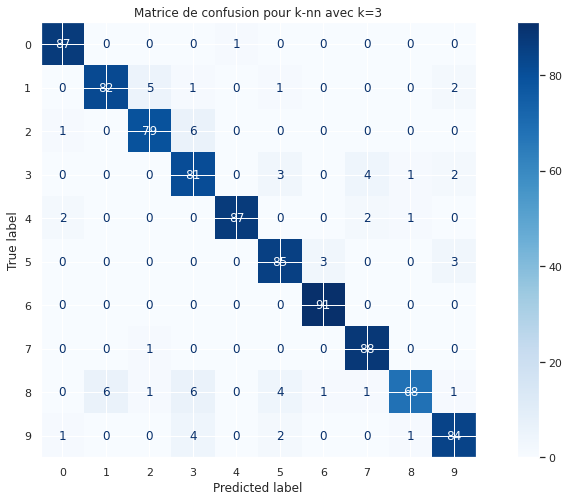

In [37]:
ShowConfusionMatrix(30,digit_X_train, digit_y_train, digit_X_test, digit_y_test)    

### Question 14

In [40]:
def SelectK(digits_data):
    all_k = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
    loo_curve = LOOCurve(k_range=all_k)
    loo_curve.fit_curve(digits_data.data, digits_data.target)
    loo_curve.plot()

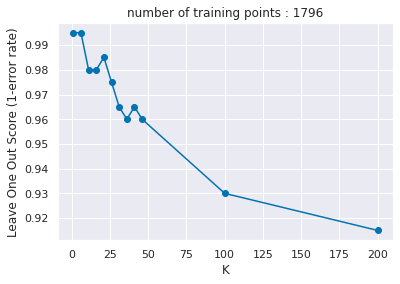

In [41]:
SelectK(digits_data)

Comme précédemment, on peut choisir $k$ comme étant le $k$ avec le plus petit taux d'erreur et supérieur à 10:
- $k$ = 21 

# Analyse Discriminante Linéaire

### Question 15

$
\begin{align}
\mathbb{P}\{Y=+1|X=x\} &= \frac{\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y=+1\}}{\mathbb{P}\{X=x\}} \\ \\
&= \frac{\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y=+1\}}{\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y=+1\} + \mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y=-1\}} \\ \\
&= \frac{f_+\pi_+}{f_+\pi_+ + f_-(1-\pi_+)}\\ 
\end{align}
$

$ \\ \\ \\ $

$
\begin{align}
\mathbb{P}\{Y=-1|X=x\} &= \frac{\mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y=-1\}}{\mathbb{P}\{X=x\}} \\ \\
&= \frac{\mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y=-1\}}{\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y=+1\} + \mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y=-1\}} \\ \\
&= \frac{f_-(1-\pi_+)}{f_+\pi_+ + f_-(1-\pi_+)} \\
\end{align}
$

### Question 16


$$
\begin{align}
\log \left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) &= \log\left(\frac{\pi_+f_+}{(1-\pi_+)f_-}\right) \\ \\
&= \log\left( 
    \frac { \pi_+ } { 1 - \pi_+}\;
    \frac{ \exp\left( -\frac{1}{2}(x-\mu_+)^T\Sigma^{-1}(x-\mu_+) \right) }
         { \exp\left( -\frac{1}{2}(x-\mu_-)^T\Sigma^{-1}(x-\mu_-) \right) } 
    \right) \\ \\
&= \log\Bigg( 
    \frac { \pi_+ } { 1 - \pi_+}
    \;\exp\left( -\frac{1}{2}(x-\mu_+)^T\Sigma^{-1}(x-\mu_+) + 
                 \frac{1}{2}(x-\mu_-)^T\Sigma^{-1}(x-\mu_-) \Bigg)  
    \right) \\ \\
&= \log\left( \frac { \pi_+ } { 1 - \pi_+} \right) +
   \frac{1}{2} \Bigg( (x-\mu_-)^T\Sigma^{-1}(x-\mu_-) - (x-\mu_+)^T\Sigma^{-1}(x-\mu_+) \Bigg)  
\end{align}
$$

$$ \\ \\ \\ $$

$\Sigma^{-1}$ est l'inverse d'une matrice symétrique, elle est donc symmétrique ce qui nous donne:
$$ \\ \\ \\ $$

$$
\begin{align}
\log \left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) 
    &= \log\left(\frac{\pi_+}{1 - \pi_+}\right)
       -\frac{1}{2}\Bigg(
            x^T\Sigma^{-1}x - 2x^T\Sigma^{-1}\mu_+ + \mu_+^T\Sigma^{-1}\mu_+
            - (x^T\Sigma^{-1}x - 2x^T\Sigma^{-1}\mu_- + \mu_-^T\Sigma^{-1}\mu_-)
        \Bigg) \\
    &= \log\left(\frac{\pi_+}{1 - \pi_+}\right)
       +\frac{1}{2}\Bigg(
        2x^T\Sigma^{-1}(\mu_- - \mu_+) + \mu_+^T\Sigma^{-1}\mu_+ - \mu_-^T\Sigma^{-1}\mu_-
    \Bigg) \\
    &= \log\left(\frac{\pi_+}{1 - \pi_+}\right)
    + x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2}\mu_-^T\Sigma^{-1}\mu_- - \frac{1}{2}\mu_+^T\Sigma^{-1}\mu_+ \\
    &= \log \left( \pi_+\right) - \log\left( 1 - \pi_+ \right)
    + x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2}\mu_-^T\Sigma^{-1}\mu_- - \frac{1}{2}\mu_+^T\Sigma^{-1}\mu_+ \\
\end{align}
$$

### Question 17

Si $X$ apartient à la classe $Y=+1$, cela voudrait dire que:

$$
\begin{align}
\mathbb{P}\{Y=+1|X=x\} > \mathbb{P}\{Y=-1|X=x\}
\end{align}
$$

et donc 

$$
\log \left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) > 0 \\ \\
$$

$$
\log \left( \pi_+\right) - \log\left( 1 - \pi_+ \right)
    + x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2}\mu_-^T\Sigma^{-1}\mu_- - \frac{1}{2}\mu_+^T\Sigma^{-1}\mu_+ > 0
$$

Si on remplace $\pi_+$, $\mu_+$ et $\mu_-$ par leurs estimateurs $m/n$, $\hat{\mu}_+$ et  $\hat{\mu}_-$:

$$
\log \left( m/n \right) - \log\left( 1 - m/n \right)
    + x^T\Sigma^{-1}(\hat{\mu}_+ - \hat{\mu}_-) + \frac{1}{2}\hat{\mu}_-^T\Sigma^{-1}\hat{\mu}_- - \frac{1}{2}\hat{\mu}_+^T\Sigma^{-1}\hat{\mu}_+ > 0 \\ \\
$$

$$
x^T\Sigma^{-1}(\hat{\mu}_+ - \hat{\mu}_-) > \frac{1}{2}\hat{\mu}_+^T\Sigma^{-1}\hat{\mu}_+ - \frac{1}{2}\hat{\mu}_-^T\Sigma^{-1}\hat{\mu}_-  + \log\left( 1 - m/n \right) - \log\left( m/n \right)
$$

### Question 18

In [54]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        
        self.mu_plus   = None
        self.mu_minus  = None
        self.sig_inv   = None
        self.r         = None
    
    def fit(self, X, y):
        
        m = (y == +1).sum()
        n = y.shape[0] 
        
        X_plus  = X[ y == +1 ]
        X_minus = X[ y == -1 ]
        
        self.mu_plus  = X_plus.mean(axis=0)
        self.mu_minus = X_minus.mean(axis=0)
        
        sig_plus  = np.cov(X_plus.T)
        sig_minus = np.cov(X_minus.T)
        
        sig = 1/(n-2) * ((m-1) * sig_plus + (n-m-1) * sig_minus)
        self.sig_inv = np.linalg.inv(sig)

        r_plus  = 1/2 * self.mu_plus.T  @ self.sig_inv @ self.mu_plus
        r_minus = 1/2 * self.mu_minus.T @ self.sig_inv @ self.mu_minus
        self.r  = r_plus - r_minus + np.log(n/m -1) # right term
   
        return self
        
    def predict(self, X):
        l = X @ self.sig_inv @ (self.mu_plus - self.mu_minus) # left term
        return (2*(l > self.r)-1) # from (0,1) to (-1,1)

### Question 19

In [43]:
def CompareLDA(n, m):
    
    X_train, X_test, y_train, y_test = gen_bi_gauss_prop(n, m, 0.8)
    
    my_lda = LDAClassifier()
    sk_lda = LinearDiscriminantAnalysis()

    my_lda.fit(X_train, y_train)
    sk_lda.fit(X_train, y_train)
    
    def f_my_pred(_x):
        return my_lda.predict(_x)
    
    def f_sk_pred(_x):
        return sk_lda.predict(_x)
    
    my_error = (f_my_pred(X_test) != y_test).mean()
    sk_error = (f_sk_pred(X_test) != y_test).mean()
    
    print("Taux d'erreur pour LDAClassifier:              %f"%my_error) 
    print("Taux d'erreur pour LinearDiscriminantAnalysis: %f"%sk_error) 

In [44]:
CompareLDA(1000, 200)

Taux d'erreur pour LDAClassifier:              0.038750
Taux d'erreur pour LinearDiscriminantAnalysis: 0.038750


### Question 20

In [45]:
def VisuLda():
      
    X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.4)
    lda = LDAClassifier().fit(X_train, y_train)
        
    def f_pred(x):
        return lda.predict(x)
    
    plt.close("all")
    plt.figure(1, figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('LDA dataset #1') 
    frontiere_new(f_pred, X_test, y_test)
    
    X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.4)
    lda = LDAClassifier().fit(X_train, y_train)
    
    plt.subplot(1, 2, 2)
    plt.title('LDA dataset #3')      
    frontiere_new(f_pred, X_test, y_test)

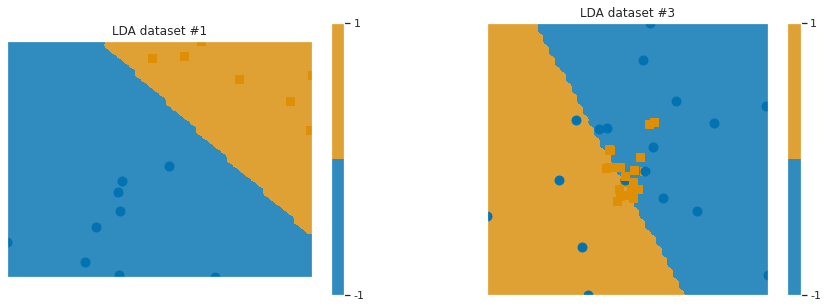

In [46]:
VisuLda()

On voit aisément que le classifieur LDA est moins performant avec le dataset #3 qu'avec le dataset #1.
- Cela découle de la nature des données générées :
    - #1: les données des deux classes sont centrées au tour deux moyennes différentes [1,1] et [-1,-1] ce qui rend ce dataset facilement séparable.
    - #2: les données sont centrées au tour de zéro [0,0] pour les deux classes ce qui les rend plus difficilement séparables.

# Méthode discriminative avec régression logistique

### Question 21

In [47]:
def CompareLdaLogisticReg(n, m ):
    
    X_train, X_test, y_train, y_test = gen_bi_gauss_prop(n,m)
    lreg = linear_model.LogisticRegression().fit(X_train, y_train)
    lda  = LinearDiscriminantAnalysis().fit(X_train, y_train)
    
    print()
    print("  score logistic regression:          %f" %lreg.score(X_test, y_test))
    print("  score linear Discriminant Analysis: %f" %lda.score(X_test, y_test))
    print()
    return lreg

In [48]:
print("Comparaison avec [y=1::500 Obs | y=-1::500 Obs]:")
lreg = CompareLdaLogisticReg(1000,500)
print("Comparaison avec [y=1::950 Obs | y=-1::50 Obs]:")
lreg = CompareLdaLogisticReg(1000,950)

Comparaison avec [y=1::500 Obs | y=-1::500 Obs]:

  score logistic regression:          0.950000
  score linear Discriminant Analysis: 0.950000

Comparaison avec [y=1::950 Obs | y=-1::50 Obs]:

  score logistic regression:          0.995000
  score linear Discriminant Analysis: 0.995000



- Dans le cas équilibré `[y=1::500 Obs | y=-1::500 Obs]`:
    - le score est du LDA est très légérement meilleur par rapport à la régression logistque
- Dans le cas déséquilibré `[y=1::950 Obs | y=-1::50 Obs]`:
    - le score est du LDA et de la régression logistque sont identiques.

### Question 22

In [49]:
print(lreg.coef_)
print(lreg.intercept_)

[[2.08581177 2.05631972]]
[2.57203813]


une maniére de voir `coef_` et `intercept_` et de considérer l'Hypothése fondamentale de la régréssin logistique:

    
$$
\log\left(
    \frac{\mathbb{P}\{X=x|Y=+1\}}{\mathbb{P}\{X=x|Y=-1\}} 
\right)
= b_0 + b_1 x_1 + \dots + b_p x_p
$$

et dans laquelle, on aurait:
   - `coef_` = $\left( b_1, \dots ,b_p \right)$
   - `intercept_` = $b_0 $

ou aussi dans la fonction de classification $g(x)$ :
    
$$
\begin{align}
g(x) = \frac{exp( b_0 + b_1 x_1 + \dots + b_p x_p )}{ 1 + exp( b_0 + b_1 x_1 + \dots + b_p x_p )} 
\end{align}
$$

### Question 23

In [50]:
def VisuLogisticReg(X, y, dataset_nb):
    X_train, y_train, X_test, y_test = split_data(X, y)
    lreg = linear_model.LogisticRegression().fit(X_train, y_train)
    
    def f_lreg_pred(x):
        return lreg.predict(x.reshape(1,-1))

    plt.close("all")
    plt.figure(1, figsize=(15, 5))
    plt.title('logistic regression [datase #%d]'%dataset_nb)      
    frontiere_new(f_lreg_pred, X, y)
    plt.show()

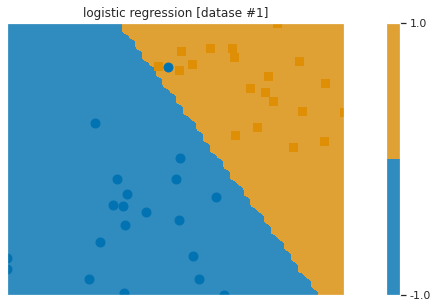

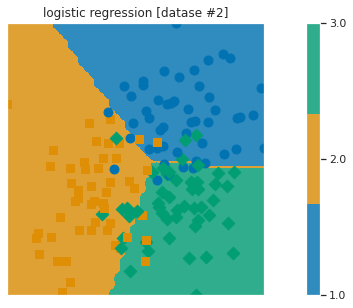

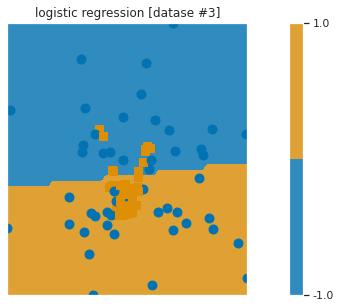

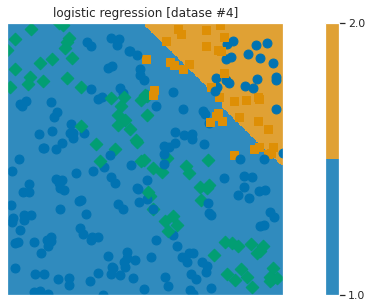

In [51]:
VisuLogisticReg(X2,  y2,  1)
VisuLogisticReg(X3,  y3,  2)
VisuLogisticReg(Xc,  yc,  3)
VisuLogisticReg(Xch, ych, 4)

### Question 24

In [52]:
def LogisticRegDigit(digit_X_train, digit_y_train, digit_X_test, digit_y_test):
    lreg  = linear_model.LogisticRegression().fit(digit_X_train, digit_y_train)
    y_pred = lreg.predict(digit_X_test)
    error = (y_pred != digit_y_test).mean()
    print("Le taux d'erreur pour la régression logistic avec le dataset DIGIT est:%f"
          %error)

In [53]:
LogisticRegDigit(digit_X_train, digit_y_train, digit_X_test, digit_y_test)

Le taux d'erreur pour la régression logistic avec le dataset DIGIT est:0.070078
